# Libraries

In [ ]:
!pip install tensorflow
!pip install tensorflow-addons
!pip install matplotlib
!pip install opencv-python
!pip install numpy

Traceback (most recent call last):
  File "<frozen importlib._bootstrap>", line 1027, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1006, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 688, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/rich/color_triplet.py", line 4, in <module>
    class ColorTriplet(NamedTuple):
  File "/usr/lib/python3.10/typing.py", line 2279, in __new__
    nm_tpl = _make_nmtuple(typename, types.items(),
  File "/usr/lib/python3.10/typing.py", line 2251, in _make_nmtuple
    nm_tpl = collections.namedtuple(name, fields,
  File "/usr/lib/python3.10/collections/__init__.py", line 414, in namedtuple
    __new__ = eval(code, namespace)
  File "<string>", line 1, in <module>
KeyboardInterrupt

During handling of the above exception, another excep

In [ ]:
!pip install -U segmentation-models==1.0.1
!pip install keras-unet-collection

In [ ]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import Sequence, to_categorical
from sklearn.model_selection import train_test_split
from google.colab import drive
import segmentation_models as sm
from concurrent.futures import ThreadPoolExecutor
from keras_unet_collection import models as unet_collection
sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

# Seed

In [ ]:
os.environ['PYTHONHASHSEED'] = str(42)
np.random.seed(42)
tf.random.set_seed(42)

# HyperParams


In [ ]:
batch_size = 16
epochs = 100
lr = 0.0001
width = 512
height = 384
backbone = 'efficientnetb4'

# Mount drive

In [ ]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir("/content/drive/MyDrive/DAP391_G7_Semantic Classification for Urban Planning Assessment/Data")
os.listdir()

['.ipynb_checkpoints',
 'Final',
 'Labelled Data',
 'Data_New',
 'Data_New.zip',
 'NewVal.zip',
 'Checkpoints',
 'Tensorboard',
 'CSVLogger.csv',
 'CSVLogger_unet3p.csv',
 'CSVLogger_unet3p.gsheet',
 'CSVLogger_unet_path.csv']

# Load Data

In [ ]:
IMG_DIR = 'Data_New/Train/Imgs/TrainingSet'
MASK_DIR = 'Data_New/Train/Masks/SegmentationClass'

def load_image(img_path, mask_path, width, height):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (width, height))
    img=img/255.0
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (width, height))
    mask = mask/255.0
    mask = (mask > 0).astype(np.uint8)
    return img, mask

def load_images(img_dir, mask_dir, height, width):

    images = []
    masks = []

    valid_extensions = ('.jpg', '.png')  # Valid extensions to filter by

    with ThreadPoolExecutor() as executor:
        # List and sort the image and mask file paths, filtering by valid extensions
        image_paths = sorted([os.path.join(img_dir, file) for file in os.listdir(img_dir)
                              if file.lower().endswith(valid_extensions)])
        mask_paths = sorted([os.path.join(mask_dir, file) for file in os.listdir(mask_dir)
                             if file.lower().endswith(valid_extensions)])

        print(f'Loaded {len(image_paths)} images and {len(mask_paths)} masks')

        results = executor.map(lambda p: load_image(p[0], p[1], width, height), zip(image_paths, mask_paths))
        imgs, masks_tmp = zip(*results)
        images.extend(imgs)
        masks.extend(masks_tmp)


    return np.array(images), np.array(masks)

images, masks = load_images(IMG_DIR, MASK_DIR, height, width)


Loaded 2328 images and 2328 masks


In [ ]:
print(images.shape)
print(masks.shape)

(2328, 384, 512, 3)
(2328, 384, 512)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(1862, 384, 512, 3)
(466, 384, 512, 3)
(1862, 384, 512)
(466, 384, 512)


## Data Gen

In [ ]:
# def create_segmentation_generator(image_dir, mask_dir, batch_size, target_size, num_classes):
#     """
#     Creates a data generator for semantic segmentation tasks.

#     Args:
#         image_dir: Path to the directory containing images.
#         mask_dir: Path to the directory containing corresponding masks.
#         batch_size: Batch size for the generator.
#         target_size: Tuple specifying the desired image and mask size (height, width).
#         num_classes: Number of segmentation classes.

#     Returns:
#         A data generator that yields batches of (image, mask) pairs.
#     """

#     # Image data generator for preprocessing images
#     image_datagen = ImageDataGenerator(
#         rescale=1./255,  # Normalize pixel values
#     )

#     # Generator for images
#     image_generator = image_datagen.flow_from_directory(
#         image_dir,
#         target_size=target_size,
#         batch_size=batch_size,
#         class_mode=None,  # No class labels for images
#         seed=42  # Set seed for reproducibility
#     )

#     # Generator for masks (similar to image generator, but with grayscale loading)
#     mask_datagen = ImageDataGenerator(
#         rescale=1./255,  # Normalize pixel values
#     )

#     mask_generator = mask_datagen.flow_from_directory(
#         mask_dir,
#         target_size=target_size,
#         batch_size=batch_size,
#         class_mode=None,  # No class labels for masks
#         color_mode='grayscale',  # Load masks as grayscale
#         seed=42
#     )

#     # Combine image and mask generators
#     def combined_generator():
#         while True:
#             images = next(image_generator)
#             masks = next(mask_generator)

#             # Convert masks to categorical (one-hot encoded)

#             yield images, masks

#     return combined_generator()

# # Example usage:
# image_dir = 'Data_New/Train/Imgs'
# mask_dir = 'Data_New/Train/Masks'
# val_img_dir = 'Data_New/Val/Imgs'
# val_mask_dir = 'Data_New/Val/Masks'
# target_size = (height, width)
# num_classes = 1 # Number of segmentation classes

# train_generator = create_segmentation_generator(image_dir, mask_dir, batch_size, target_size, num_classes)
# validation_generator = create_segmentation_generator(val_img_dir, val_mask_dir, batch_size, target_size, num_classes)


### Train_Test Split

# Models Make

## Unet 3+

In [ ]:
unet3plus=unet_collection.unet_3plus_2d((height, width, 3), n_labels=1, filter_num_down=[64, 128, 256, 512],
                             filter_num_skip='auto', filter_num_aggregate='auto',
                             stack_num_down=2, stack_num_up=1, activation='ReLU', output_activation='Sigmoid',
                             batch_norm=True, pool='max', unpool=False, deep_supervision=True, name='unet3plus')
unet3plus.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy', sm.metrics.IOUScore(threshold=0.5), sm.metrics.Recall(threshold=0.5), sm.metrics.Precision(threshold=0.5)])
unet3plus.summary()

Automated hyper-parameter determination is applied with the following details:
----------
	Number of convolution filters after each full-scale skip connection: filter_num_skip = [64, 64, 64]
	Number of channels of full-scale aggregated feature maps: filter_num_aggregate = 256
----------
deep_supervision = True
names of output tensors are listed as follows ("sup0" is the shallowest supervision layer;
"final" is the final output layer):

	unet3plus_output_sup0_activation
	unet3plus_output_sup1_activation
	unet3plus_output_sup2_activation
	unet3plus_output_final_activation


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 384, 512, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet3plus_down0_0         │ (None, 384, 512, 64)   │          1,728 │ input_layer_5[0][0]    │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet3plus_down0_0_bn      │ (None, 384, 512, 64)   │            256 │ unet3plus_down0_0[0][… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet3plus_down0_0_activa… │ (None, 384, 512, 64)   │              0 │ unet3plus_down0_0_bn[… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet3plus_down0_1         │ (None, 384, 512, 64)   │         36,864 │ unet3plus_down0_0_act… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet3plus_down0_1_bn      │ (None, 384, 512, 64)   │            256 │ unet3plus_down0_1[0][… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet3plus_down0_1_activa… │ (None, 384, 512, 64)   │              0 │ unet3plus_down0_1_bn[… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet3plus_down1_encode_m… │ (None, 192, 256, 64)   │              0 │ unet3plus_down0_1_act… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet3plus_down1_conv_0    │ (None, 192, 256, 128)  │         73,728 │ unet3plus_down1_encod… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet3plus_down1_conv_0_bn │ (None, 192, 256, 128)  │            512 │ unet3plus_down1_conv_… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet3plus_down1_conv_0_a… │ (None, 192, 256, 128)  │              0 │ unet3plus_down1_conv_… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet3plus_down1_conv_1    │ (None, 192, 256, 128)  │        147,456 │ unet3plus_down1_conv_… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet3plus_down1_conv_1_bn │ (None, 192, 256, 128)  │            512 │ unet3plus_down1_conv_… │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 7,880,290 (30.06 MB)

 Trainable params: 7,872,994 (30.03 MB)

 Non-trainable params: 7,296 (28.50 KB)

## Unet EffnetB7

In [ ]:
Unet_EffnetB7=sm.Unet(backbone_name=backbone, encoder_weights='imagenet', classes=1, activation='sigmoid', input_shape=(height, width, 3))
Unet_EffnetB7.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
Unet_EffnetB7.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 384, 512, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 192, 256, 48)   │          1,296 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 192, 256, 48)   │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 192, 256, 48)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 192, 256, 48)   │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 192, 256, 48)   │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 192, 256, 48)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand         │ (None, 1, 1, 48)       │            624 │ block1a_se_reduce[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_excite         │ (None, 192, 256, 48)   │              0 │ block1a_activation[0]… │
│ (Multiply)                │                        │                │ block1a_se_expand[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 192, 256, 24)   │          1,152 │ block1a_se_excite[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 192, 256, 24)   │             96 │ block1a_project_conv[… │
│ (BatchNormalization) 

 Total params: 25,735,017 (98.17 MB)

 Trainable params: 25,607,833 (97.69 MB)

 Non-trainable params: 127,184 (496.81 KB)

## Linknet EffnetB7

In [ ]:
Linknet_EffnetB7=sm.Linknet(backbone_name=backbone, encoder_weights='imagenet', classes=1, activation='sigmoid', input_shape=(height, width, 3))
Linknet_EffnetB7.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
Linknet_EffnetB7.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 384, 512, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 192, 256, 48)   │          1,296 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 192, 256, 48)   │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 192, 256, 48)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 192, 256, 48)   │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 192, 256, 48)   │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 192, 256, 48)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand         │ (None, 1, 1, 48)       │            624 │ block1a_se_reduce[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_excite         │ (None, 192, 256, 48)   │              0 │ block1a_activation[0]… │
│ (Multiply)                │                        │                │ block1a_se_expand[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 192, 256, 24)   │          1,152 │ block1a_se_excite[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 192, 256, 24)   │             96 │ block1a_project_conv[… │
│ (BatchNormalization) 

 Total params: 21,718,217 (82.85 MB)

 Trainable params: 21,586,297 (82.35 MB)

 Non-trainable params: 131,920 (515.31 KB)

## Check points & Logs


In [ ]:
checkpoint_path = '/content/drive/MyDrive/DAP391_G7_Semantic Classification for Urban Planning Assessment/Data/Checkpoints'
os.makedirs(checkpoint_path, exist_ok=True)
checkpoint_unet3p_path = os.path.join(checkpoint_path, 'unet3p.keras')
checkpoint_unet_path = os.path.join(checkpoint_path, 'unet_effnetb7.keras')
checkpoint_linknet_path = os.path.join(checkpoint_path, 'linknet_effnetb7.keras')

# Define the checkpoint callback
checkpoint_unet3p = ModelCheckpoint(
    checkpoint_unet3p_path,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_freq='epoch'
)

checkpoint_unet_path = ModelCheckpoint(
    checkpoint_unet_path,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_freq='epoch'
)

checkpoint_linknet_path = ModelCheckpoint(
    checkpoint_linknet_path,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_freq='epoch'
)

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    verbose=1,
    mode='max',
    restore_best_weights=True
)

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=1,
    mode='min'
)

# Define the CSVLogger callback
csv_logger_unet3p = CSVLogger(
    '/content/drive/MyDrive/DAP391_G7_Semantic Classification for Urban Planning Assessment/Data/CSVLogger_unet3p.csv',
    append=True
)

csv_logger_unet_path = CSVLogger(
    '/content/drive/MyDrive/DAP391_G7_Semantic Classification for Urban Planning Assessment/Data/CSVLogger_unet_path.csv',
    append=True
)

csv_logger_linknet_path = CSVLogger(
    '/content/drive/MyDrive/DAP391_G7_Semantic Classification for Urban Planning Assessment/Data/CSVLogger_linknet_path.csv',
    append=True
)

callbacks = [early_stopping, reduce_lr]


# Model Train

In [ ]:
Unet3p_his = unet3plus.fit(X_train,y_train, steps_per_epoch=len(X_train)//batch_size, epochs=epochs, validation_data=(X_val, y_val), callbacks=[callbacks, checkpoint_unet3p, csv_logger_unet3p])

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'gamma', 'beta', 'gamma', 'beta', 'kernel', 'kernel', 'kernel', 'gamma', 'beta', 'gamma', 'beta', 'gamma', 'beta', 'kernel', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


110/116 ━━━━━━━━━━━━━━━━━━━━ 4s 818ms/step - loss: 0.5754 - unet3plus_output_sup0_activation_accuracy: 0.6601

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


116/116 ━━━━━━━━━━━━━━━━━━━━ 271s 1s/step - loss: 0.5740 - unet3plus_output_sup0_activation_accuracy: 0.6610 - val_loss: 0.6166 - val_unet3plus_output_sup0_activation_accuracy: 0.6423 - learning_rate: 1.0000e-04
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,unet3plus_output_sup0_activation_accuracy,val_loss,val_unet3plus_output_sup0_activation_accuracy
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


116/116 ━━━━━━━━━━━━━━━━━━━━ 29s 253ms/step - loss: 0.5152 - unet3plus_output_sup0_activation_accuracy: 0.6915 - val_loss: 0.6445 - val_unet3plus_output_sup0_activation_accuracy: 0.6423 - learning_rate: 1.0000e-04
Epoch 3/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 29s 253ms/step - loss: 0.4867 - unet3plus_output_sup0_activation_accuracy: 0.6988 - val_loss: 0.6943 - val_unet3plus_output_sup0_activation_accuracy: 0.6423 - learning_rate: 1.0000e-04
Epoch 4/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 29s 253ms/step - loss: 0.4580 - unet3plus_output_sup0_activation_accuracy: 0.7061 - val_loss: 0.6298 - val_unet3plus_output_sup0_activation_accuracy: 0.6397 - learning_rate: 1.0000e-04
Epoch 5/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 29s 253ms/step - loss: 0.4229 - unet3plus_output_sup0_activation_accuracy: 0.7419 - val_loss: 0.5326 - val_unet3plus_output_sup0_activation_accuracy: 0.8291 - learning_rate: 1.0000e-04
Epoch 6/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 29s 253ms/step - loss: 0.3721 - unet3plus_output_sup0_activation_ac

In [ ]:
Unet_EffnetB7_his = Unet_EffnetB7.fit(X_train,y_train, steps_per_epoch=len(X_train)//batch_size, epochs=epochs, validation_data=(X_val, y_val), callbacks=[callbacks, checkpoint_unet_path, csv_logger_unet_path])

Epoch 1/100
110/116 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7877 - loss: 0.4993   

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_accuracy improved from -inf to 0.90238, saving model to /content/drive/MyDrive/DAP391_G7_Semantic Classification for Urban Planning Assessment/Data/Checkpoints/unet_effnetb7.keras
116/116 ━━━━━━━━━━━━━━━━━━━━ 342s 1s/step - accuracy: 0.7916 - loss: 0.4935 - val_accuracy: 0.9024 - val_loss: 0.4284 - learning_rate: 1.0000e-04
Epoch 2/100
110/116 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - accuracy: 0.9281 - loss: 0.2418
Epoch 2: val_accuracy improved from 0.90238 to 0.92354, saving model to /content/drive/MyDrive/DAP391_G7_Semantic Classification for Urban Planning Assessment/Data/Checkpoints/unet_effnetb7.keras
116/116 ━━━━━━━━━━━━━━━━━━━━ 26s 221ms/step - accuracy: 0.9283 - loss: 0.2409 - val_accuracy: 0.9235 - val_loss: 0.2552 - learning_rate: 1.0000e-04
Epoch 3/100
110/116 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - accuracy: 0.9435 - loss: 0.1806
Epoch 3: val_accuracy improved from 0.92354 to 0.93976, saving model to /content/drive/MyDrive/DAP391_G7_Semantic Classification for Urban

In [ ]:
Linknet_EffnetB7_his = Linknet_EffnetB7.fit(X_train,y_train, steps_per_epoch=len(X_train)//batch_size, epochs=epochs, validation_data=(X_val, y_val), callbacks=[callbacks, checkpoint_linknet_path, csv_logger_linknet_path])

Epoch 1/100
110/116 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6455 - loss: 0.6371   

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_accuracy improved from -inf to 0.85202, saving model to /content/drive/MyDrive/DAP391_G7_Semantic Classification for Urban Planning Assessment/Data/Checkpoints/linknet_effnetb7.keras
116/116 ━━━━━━━━━━━━━━━━━━━━ 342s 1s/step - accuracy: 0.6516 - loss: 0.6307 - val_accuracy: 0.8520 - val_loss: 0.4451 - learning_rate: 1.0000e-04
Epoch 2/100
110/116 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.9129 - loss: 0.3023
Epoch 2: val_accuracy improved from 0.85202 to 0.91067, saving model to /content/drive/MyDrive/DAP391_G7_Semantic Classification for Urban Planning Assessment/Data/Checkpoints/linknet_effnetb7.keras
116/116 ━━━━━━━━━━━━━━━━━━━━ 25s 219ms/step - accuracy: 0.9132 - loss: 0.3012 - val_accuracy: 0.9107 - val_loss: 0.3336 - learning_rate: 1.0000e-04
Epoch 3/100
110/116 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.9325 - loss: 0.2277
Epoch 3: val_accuracy improved from 0.91067 to 0.92752, saving model to /content/drive/MyDrive/DAP391_G7_Semantic Classification for

# Model Eval

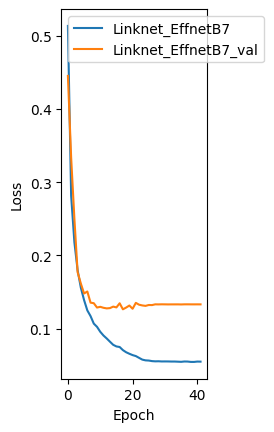

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(Unet3p_his.history['loss'], label='Unet3p')
plt.plot(Unet3p_his.history['val_loss'], label='Unet3p_val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,3,2)
plt.plot(Unet_EffnetB7_his.history['loss'], label='Unet_EffnetB7')
plt.plot(Unet_EffnetB7_his.history['val_loss'], label='Unet_EffnetB7_val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,3,3)
plt.plot(Linknet_EffnetB7_his.history['loss'], label='Linknet_EffnetB7')
plt.plot(Linknet_EffnetB7_his.history['val_loss'], label='Linknet_EffnetB7_val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


KeyError: 'accuracy'

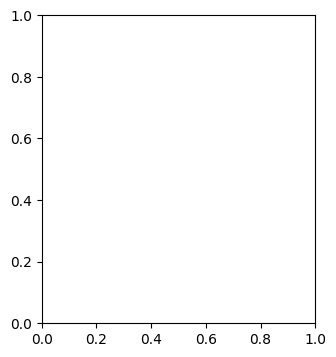

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(Unet3p_his.history['accuracy'], label='Unet3p')
plt.plot(Unet3p_his.history['val_accuracy'], label='Unet3p_val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,3,2)
plt.plot(Unet_EffnetB7_his.history['accuracy'], label='Unet_EffnetB7')
plt.plot(Unet_EffnetB7_his.history['val_accuracy'], label='Unet_EffnetB7_val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,3,3)
plt.plot(Linknet_EffnetB7_his.history['accuracy'], label='Linknet_EffnetB7')
plt.plot(Linknet_EffnetB7_his.history['val_accuracy'], label='Linknet_EffnetB7_val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


KeyError: 'iou_score'

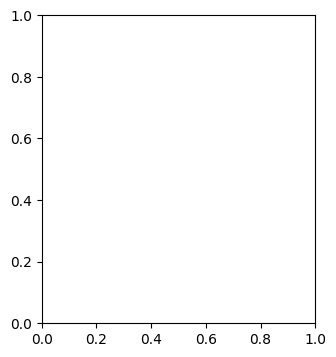

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(Unet3p_his.history['iou_score'], label='Unet3p')
plt.plot(Unet3p_his.history['val_iou_score'], label='Unet3p_val')
plt.xlabel('Epoch')
plt.ylabel('IOU')
plt.legend()

plt.subplot(1,3,2)
plt.plot(Unet_EffnetB7_his.history['iou_score'], label='Unet_EffnetB7')
plt.plot(Unet_EffnetB7_his.history['val_iou_score'], label='Unet_EffnetB7_val')
plt.xlabel('Epoch')
plt.ylabel('IOU')
plt.legend()

plt.subplot(1,3,3)
plt.plot(Linknet_EffnetB7_his.history['iou_score'], label='Linknet_EffnetB7')
plt.plot(Linknet_EffnetB7_his.history['val_iou_score'], label='Linknet_EffnetB7_val')
plt.xlabel('Epoch')
plt.ylabel('IOU')
plt.legend()

plt.show()



KeyError: 'recall'

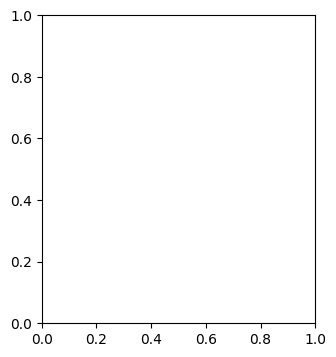

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(Unet3p_his.history['recall'], label='Unet3p')
plt.plot(Unet3p_his.history['val_recall'], label='Unet3p_val')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.subplot(1,3,2)
plt.plot(Unet_EffnetB7_his.history['recall'], label='Unet_EffnetB7')
plt.plot(Unet_EffnetB7_his.history['val_recall'], label='Unet_EffnetB7_val')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.subplot(1,3,3)
plt.plot(Linknet_EffnetB7_his.history['recall'], label='Linknet_EffnetB7')
plt.plot(Linknet_EffnetB7_his.history['val_recall'], label='Linknet_EffnetB7_val')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.show()

KeyError: 'precision'

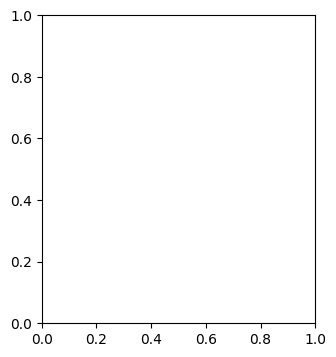

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(Unet3p_his.history['precision'], label='Unet3p')
plt.plot(Unet3p_his.history['val_precision'], label='Unet3p_val')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

plt.subplot(1,3,2)
plt.plot(Unet_EffnetB7_his.history['precision'], label='Unet_EffnetB7')
plt.plot(Unet_EffnetB7_his.history['val_precision'], label='Unet_EffnetB7_val')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

plt.subplot(1,3,3)
plt.plot(Linknet_EffnetB7_his.history['precision'], label='Linknet_EffnetB7')
plt.plot(Linknet_EffnetB7_his.history['val_precision'], label='Linknet_EffnetB7_val')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

plt.show()


In [ ]:
import tensorflow as tf
from numba import cuda

# Clear TensorFlow GPU memory
tf.keras.backend.clear_session()

# Optionally, also reset GPU memory using Numba (if you are using CUDA)
device = cuda.get_current_device()
device.reset()
